# Email Spam/Ham Classification Test
http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html <br>
https://spamassassin.apache.org/old/publiccorpus/

In [9]:
#Quick conversion of formats of files.
#Enron Database
#Iterate over each text email file and convert to a csv file.
import os
import string
dirList = ['Data/email_corpus/enron/spam/', 'Data/email_corpus/enron/ham/']
outFile = 'Data/email_corpus/enron.csv'
for dir in dirList:
    for file in os.listdir(dir):
        if file.endswith(".txt"):
            with open(dir+file, 'r', errors="ignore") as f:
                with open(outFile, 'a') as out:
                    #add spam/ham label to each message/email
                    if dir == 'Data/email_corpus/enron/spam/':
                        out.write('spam,')
                    else:
                        out.write('ham,')
                    out.write('"')
                    #strip lines starting with "Subject", "to:", "cc:"
                    for line in f:
                        if not line.lower().startswith('subject: ') and not line.lower().startswith('to: ') and not line.lower().startswith('cc: '):
                            #strip message of any numbers
                            line = ''.join([i for i in line if not i.isdigit()])
                            #strip message of all punctuation, symbols, and special characters except spaces
                            line = ''.join([i for i in line if i in string.ascii_letters or i == ' '])
                            #strip message of any URLs
                            line = ' '.join([i for i in line.split() if not i.startswith('http')])
                            #strip message of any email addresses
                            line = ' '.join([i for i in line.split() if not '@' in i])
                            out.write(line)
                            
                    out.write('"\n')

In [28]:
#Quick conversion of text to files
#Spam Assassin Database
#Iterate over each text email file and convert to a csv file.
import os
import string
import email
dirList = ['Data/email_corpus/spam_assassin/spam/', 'Data/email_corpus/spam_assassin/ham/']
outFile = 'Data/email_corpus/spam_assassin.csv'
for dir in dirList:
    for file in os.listdir(dir):
        with open(dir+file, 'r', errors="ignore") as f:
            with open(outFile, 'a') as out:
                #add spam/ham label to each message/email
                if dir == 'Data/email_corpus/spam_assassin/spam/':
                    out.write('spam,')
                else:
                    out.write('ham,')
                out.write('"')
                #email is in MIME format, extract body of email
                msg = email.message_from_file(f)
                body = str(msg.get_payload())
                #strip message of any numbers
                body = ''.join([i for i in body if not i.isdigit()])
                #strip message of all punctuation, symbols, and special characters except spaces
                body = ''.join([i for i in body if i in string.ascii_letters or i == ' '])
                #strip message of any URLs
                body = ' '.join([i for i in body.split() if not i.startswith('http')])
                #strip message of any email addresses
                body = ' '.join([i for i in body.split() if not '@' in i])
                out.write(body)                            
                out.write('"\n')

## Feature Extraction

### Data Input

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#enron
enron = pd.read_csv('Data/email_corpus/enron.csv', names=['label', 'message'], encoding='latin-1', quotechar='"')
enron.dropna(inplace=True) #drop any rows with missing values
enron.drop_duplicates(inplace=True) #drop any duplicate rows

#spam assassin
spam_assassin = pd.read_csv('Data/email_corpus/spam_assassin.csv', names=['label', 'message'], encoding='latin-1', quotechar='"')
spam_assassin.dropna(inplace=True) #drop any rows with missing values
spam_assassin.drop_duplicates(inplace=True) #drop any duplicate rows

email_corpus = spam_assassin

### Pre-processing
- Remove Stopwords
- Stemming/Lematization

Ideas for pre-processing taken from: https://ijisrt.com/assets/upload/files/IJISRT21SEP728.pdf and https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

In [2]:
#Remove stopwords
'''
To Download Stopwords:
    import nltk
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')


Stopwords are commonly used words in English which have no contextual meaning in an sentence.
i.e "I like reading, so I read" --> "Like, Reading, read"
'''
from nltk.corpus import stopwords
stop = stopwords.words('english')
email_corpus['message'] = email_corpus['message'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Stemming
'''
Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

i.e adjustable --> adjust
i.e formalities --> formal
'''
from nltk.stem import PorterStemmer
st = PorterStemmer()
email_corpus['message'] = email_corpus['message'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

#Lemmatization
'''
Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

i.e was --> (to) be
i.e better --> good
'''
from textblob import Word
email_corpus['message'] = email_corpus['message'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

#Show Data
print(email_corpus.head())

  label                                            message
0  spam  mv bfcddbffccadbmv ffbcebefcdceaaamv cdcbcfaba...
1  spam  greetingsy receiv letter express interest rece...
2  spam  doctyp html public wcdtd html transitionalenht...
3  spam  htmlbodycenterhfont colorbluebth need for safe...
4  spam  fight the risk cancerhttpwwwadclickwspcfmospk ...


### Vectorisation and Splitting of Data for evaluation
TF-IDF (term frequency–inverse document frequency):
- Numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus
- Value increases proportionally to the number of times a word appears in the document
- Offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general

Ideas taken from: https://ijisrt.com/assets/upload/files/IJISRT21SEP728.pdf and https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained

In [3]:
from sklearn.utils import shuffle
email_corpus = shuffle(email_corpus)
# # TF-IDF Vectorise text
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(email_corpus['message']).toarray()
# Transform labels to binary for y
y = np.where(email_corpus['label']=='spam', 1, 0)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2022)

In [10]:
print(X_train.shape)

(3355, 117283)


## Imports (For Models)

In [4]:
import matplotlib.pyplot as plt
from qbstyles import mpl_style
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time

def plotDescent(descent):
    iterations = descent.keys()
    current_cost = descent.values()
    plt.plot(iterations, current_cost)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost reduction over time')
    mpl_style(True)
    plt.show()

def plotMultipleDescent(descentDict):
    for key, value in descentDict.items():
        iterations = value.keys()
        current_cost = value.values()
        plt.plot(iterations, current_cost, label=key)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost reduction over time')
    plt.legend()
    mpl_style(True)
    plt.show()

def plotMultipleValidationCurve(accuracyDict):
    lamda = accuracyDict.keys()
    accuracy = accuracyDict.values()
    plt.plot(lamda, accuracy)
    plt.xlabel('Lamda')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Lamda')
    mpl_style(True)
    plt.show()

''' 
Confusion Matrix:
    - Evaluate the quality of the output of a classifier
    - diagonal elements represent the number of points for which the predicted label is equal to the true label
    - off-diagonal elements are those that are mislabeled by the classifier
    - The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
'''
def printConfusionMatrix(confusionMatrix):
    print("True Negatives: ", confusionMatrix[0][0])
    print("False Positives: ", confusionMatrix[0][1])
    print("False Negatives: ", confusionMatrix[1][0])
    print("True Positives: ", confusionMatrix[1][1])

def plotConfusionMatrix(y, y_predicted):
    titles_options = [("Confusion matrix, without normalization", None),("Normalized confusion matrix", "true"),]
    for title, normalize in titles_options:
        disp = metrics.ConfusionMatrixDisplay.from_predictions(y, y_predicted, normalize=normalize)
        disp.ax_.set_title(title)
        mpl_style(True)
        plt.show()
        printConfusionMatrix(disp.confusion_matrix)
    
'''
Precision Recall Curve:
    - shows the tradeoff between precision and recall for different threshold
    - high area under the curve represents both high recall and high precision
    - high precision relates to a low false positive rate, and high recall relates to a low false negative rate

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
'''
def plotPrecisionRecall(y, y_predicted):
    disp = metrics.PrecisionRecallDisplay.from_predictions(y, y_predicted)
    mpl_style(True)
    plt.show()

'''
ROC Curve:
    - ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis
    -  “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.
    
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
'''
def plotROC(y, y_predicted):
    metrics.RocCurveDisplay.from_predictions(y, y_predicted)
    plt.plot([0, 1], [0, 1], linestyle='--')   
    mpl_style(True)
    plt.show()

def printMetrics(y, y_predicted):
    print(f'Accuracy: {metrics.accuracy_score(y, y_predicted)}') #best possible score is 1.0
    print(f'MAE: {metrics.mean_absolute_error(y, y_predicted)}') #the lower the better, 0.0 is perfect
    print(f'Precision: {metrics.precision_score(y, y_predicted)}') #the higher the better, 1.0 is perfect
    print(f'Recall: {metrics.recall_score(y, y_predicted)}') #the higher the better, 1.0 is perfect
    print(f'F1: {metrics.f1_score(y, y_predicted)}')

def plotMetrics(y, y_predicted):
    print('Confusion Matrix')
    plotConfusionMatrix(y, y_predicted)
    print('----------------------------------------------------------------------------------------------------------------')
    print('Precision Recall Curve')
    plotPrecisionRecall(y, y_predicted)
    print('----------------------------------------------------------------------------------------------------------------')
    print('ROC Curve')
    plotROC(y, y_predicted)

In [5]:
import numpy as np
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(f_wb,y):
    epsilon = 1e-5 #deal with log of 0
    return (-y * np.log(f_wb+ epsilon) - (1 - y) * np.log(1 - f_wb + epsilon)).mean()

def gradientDescent(X, y, alpha=0.001, iterations=100000):
    '''
    Alpha must be between 0 and 1
    '''
    # weights initialization
    weights = np.zeros(X.shape[1])
    beta = 0
    descent = dict()
        
    for i in range(iterations):
        #calculate new weights and beta
        z = np.dot(X, weights) + beta
        f_wb = sigmoid(z)

        #calculate gradients
        '''
        - X.T is the transpose of X (out features). 
        - Here, transpose is used to change the shape of X from (Sample, Features) to (Features, Sample) so that we can multiply it with the error vector.
        - f_wb - y is the difference between the predicted and actual values
        - Dot product is used to mulyiply the two matrices (reference explanation)

        - w.r.t to explanation, y.size is m (number of samples)
        - Summation of gradient for the jth feature is the same as the dot product of the jth column of X and the error vector
        - We are batch updating the weights, so we are using the entire dataset to calculate the gradient
        '''
        gradient = np.dot(X.T, (f_wb - y)) / y.size

        #calculate weights and beta
        weights -= alpha * gradient
        '''
        - Beta is calculated similar to the gradient, except we do not multiply it by X (i.e its transpore)
        - Sum is used here to sum up all the values in the error vector since there is only 1 beta value
        '''
        beta -= alpha * (np.sum(f_wb - y) / y.size)
      
        #calculate cost of new weight
        z = np.dot(X,weights) + beta
        f_wb = sigmoid(z)
        loss = cost(f_wb,y)  
                     
        if i % 10000 == 0:
            descent[i] = loss
            print(f'cost: {loss} \t', f'weights: {weights} \t', f'beta: {beta}')

    return weights, descent, beta

def LRpredict(X, weights, beta, threshold=0.5):
    preds = sigmoid(np.dot(X, weights) + beta)
    preds = [1 if i >= threshold else 0 for i in preds]
    return preds

def LRTrain(X, y, alpha, iterations=100000):
    weights, descent, beta = gradientDescent(X, y, alpha, iterations=iterations)
    print(f'Final weights: {weights} \n', f'Final beta: {beta}')
    return weights, beta 

def learningRateFinder(learningRates, X, y, iterations=100000):
    descentDict = dict()
    for learningRate in learningRates:
        weights, descent, beta = gradientDescent(X, y, learningRate, iterations=iterations)
        descentDict[learningRate] = descent
    plotMultipleDescent(descentDict)

In [6]:
def NBtrain(X,y, alpha=1.0):
    #number of samples
    sampleCount = X.shape[0]

    #group samples by class label
    separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]

    #calculate prior probability for each class, i.e P(y) = N_y/N_total
    classLogPrior = [np.log(len(i) / sampleCount) for i in separated] 

    #calculate P(x_i|y) with smoothing (we default to laplace smoothing, alpha = 1)
    #first calculate frequency
    count = np.array([np.array(i).sum(axis=0) for i in separated]) + alpha 
    #then calculate log probability 
    #[np.newaxis].T is simpy to transpore the array to allow for broadcasting.
    featureLogProb = np.log(count / count.sum(axis=1)[np.newaxis].T) 
    
    return classLogPrior, featureLogProb

def NBpredict(X, classLogPrior, featureLogProb):
    #calculate P(x|y)P(y)
    combinedLikelihood = [(featureLogProb * x).sum(axis=1) + classLogPrior for x in X]
    #return the class with the highest probability
    return np.argmax(combinedLikelihood, axis=1)

#use cross validation of training data to assess how well our model will perform on unseen data for different smoothing values
def alphaFinder(alphaArr, X, y):
    accuracyDict = dict()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2022)
    for alpha in alphaArr:
        classLogPrior, featureLogProb = NBtrain(X_train, y_train, alpha=alpha)
        y_pred = NBpredict(X_test, classLogPrior, featureLogProb)
        accuracyDict[alpha] = metrics.accuracy_score(y_test, y_pred)
    print(accuracyDict)
    plotMultipleValidationCurve(accuracyDict)

## Train Models

In [7]:
startTime = time.time()
weights, beta = LRTrain(X_train, y_train, alpha=1, iterations=100000)
print(f'Training time: {time.time() - startTime}')

cost: 0.6468722145972262 	 weights: [-6.71801521e-05  0.00000000e+00  0.00000000e+00 ... -2.41661439e-05
 -4.14679907e-05  0.00000000e+00] 	 beta: -0.22608047690014904
cost: 0.06953161419175045 	 weights: [ 0.02188021  0.          0.         ... -0.05955248 -0.06704052
  0.        ] 	 beta: -1.3246808049589582
cost: 0.04434002017330334 	 weights: [ 0.04778202  0.          0.         ... -0.07915979 -0.08521311
  0.        ] 	 beta: -1.4055742431527949
cost: 0.034811145407960584 	 weights: [ 0.06469631  0.          0.         ... -0.09026755 -0.09512748
  0.        ] 	 beta: -1.4822441563313897
cost: 0.02984460718858851 	 weights: [ 0.07700621  0.          0.         ... -0.09795896 -0.10177676
  0.        ] 	 beta: -1.5432614893224117
cost: 0.02680655502853618 	 weights: [ 0.08662803  0.          0.         ... -0.10383562 -0.1067217
  0.        ] 	 beta: -1.592094352046172
cost: 0.02475862826502411 	 weights: [ 0.09449263  0.          0.         ... -0.10859146 -0.11063305
  0.       

Prediction time: 0.15845704078674316s

Accuracy: 0.9691551184622262
MAE: 0.030844881537773806
Precision: 0.9620689655172414
Recall: 0.9223140495867769
F1: 0.9417721518987343
Confusion Matrix


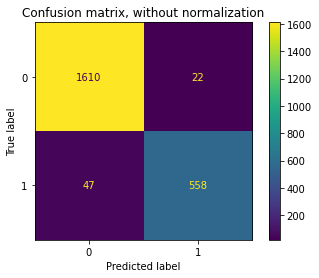

True Negatives:  1610
False Positives:  22
False Negatives:  47
True Positives:  558


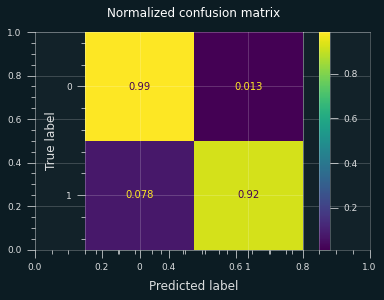

True Negatives:  0.9865196078431373
False Positives:  0.013480392156862746
False Negatives:  0.07768595041322314
True Positives:  0.9223140495867769
----------------------------------------------------------------------------------------------------------------
Precision Recall Curve


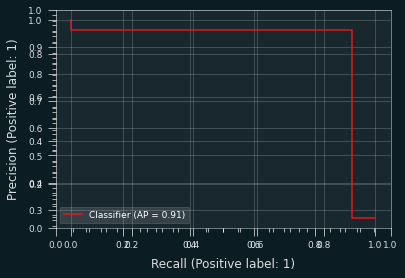

----------------------------------------------------------------------------------------------------------------
ROC Curve


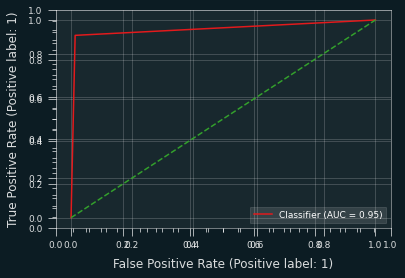

In [8]:
startTime = time.time()
LRpreds = LRpredict(X_test, weights, beta)
endTime = time.time()
print(f'Prediction time: {endTime - startTime}s\n')
printMetrics(y_test, LRpreds)
plotMetrics(y_test, LRpreds)

{0.0001: 0.96274217585693, 0.001: 0.9657228017883756, 0.01: 0.9687034277198212, 0.1: 0.9225037257824144, 1: 0.8174366616989568}


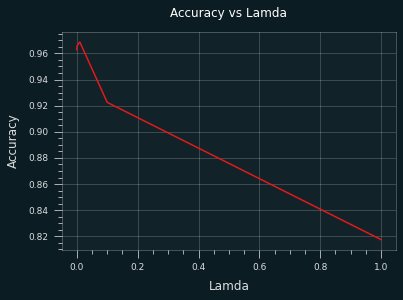

In [11]:
#Naive Bayes Model
alphaFinder([0.0001,0.001,0.01, 0.1, 1], X_train, y_train)

Naive Bayes Model

Training time: 1.083745002746582s


Prediction time: 1.6051807403564453s


Accuracy: 0.9731783638801967
MAE: 0.02682163611980331
Precision: 0.9416531604538088
Recall: 0.9603305785123967
F1: 0.9509001636661211
--------------------------------------------------------------------------------
Confusion Matrix


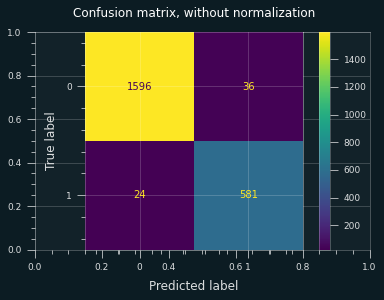

True Negatives:  1596
False Positives:  36
False Negatives:  24
True Positives:  581


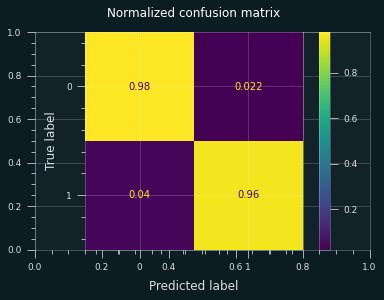

True Negatives:  0.9779411764705882
False Positives:  0.022058823529411766
False Negatives:  0.03966942148760331
True Positives:  0.9603305785123967
----------------------------------------------------------------------------------------------------------------
Precision Recall Curve


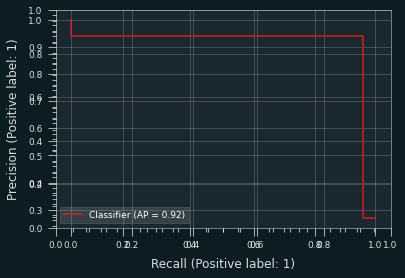

----------------------------------------------------------------------------------------------------------------
ROC Curve


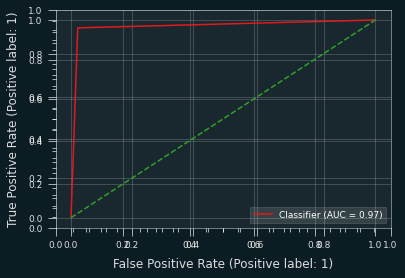

In [12]:
#Naive Bayes Model
print('Naive Bayes Model\n')
trainTimeStart = time.time()
NBclassLogPrior, NBfeatureLogProb = NBtrain(X_train, y_train, alpha=0.01) 
trainTimeEnd = time.time()
print(f'Training time: {trainTimeEnd - trainTimeStart}s\n\n')
predictTimeStart = time.time()
NBpreds = NBpredict(X_test, NBclassLogPrior, NBfeatureLogProb)
predictTimeEnd = time.time()
print(f'Prediction time: {predictTimeEnd - predictTimeStart}s\n\n')
printMetrics(y_test, NBpreds)
print("--------------------------------------------------------------------------------")
plotMetrics(y_test, NBpreds)